/var/folders/j9/wxzkbfkj0zz0zthrb7j4hjsr0000gn/T/ipykernel_352/4013911393.py:93: RuntimeWarning: invalid value encountered in scalar divide
  slope = value_diff / time_diff
/var/folders/j9/wxzkbfkj0zz0zthrb7j4hjsr0000gn/T/ipykernel_352/4013911393.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  upper_slope = slope + compression_deviation / time_diff
/var/folders/j9/wxzkbfkj0zz0zthrb7j4hjsr0000gn/T/ipykernel_352/4013911393.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  lower_slope = slope - compression_deviation / time_diff


GIF saved as 'swinging_door_autocorrelated.gif'


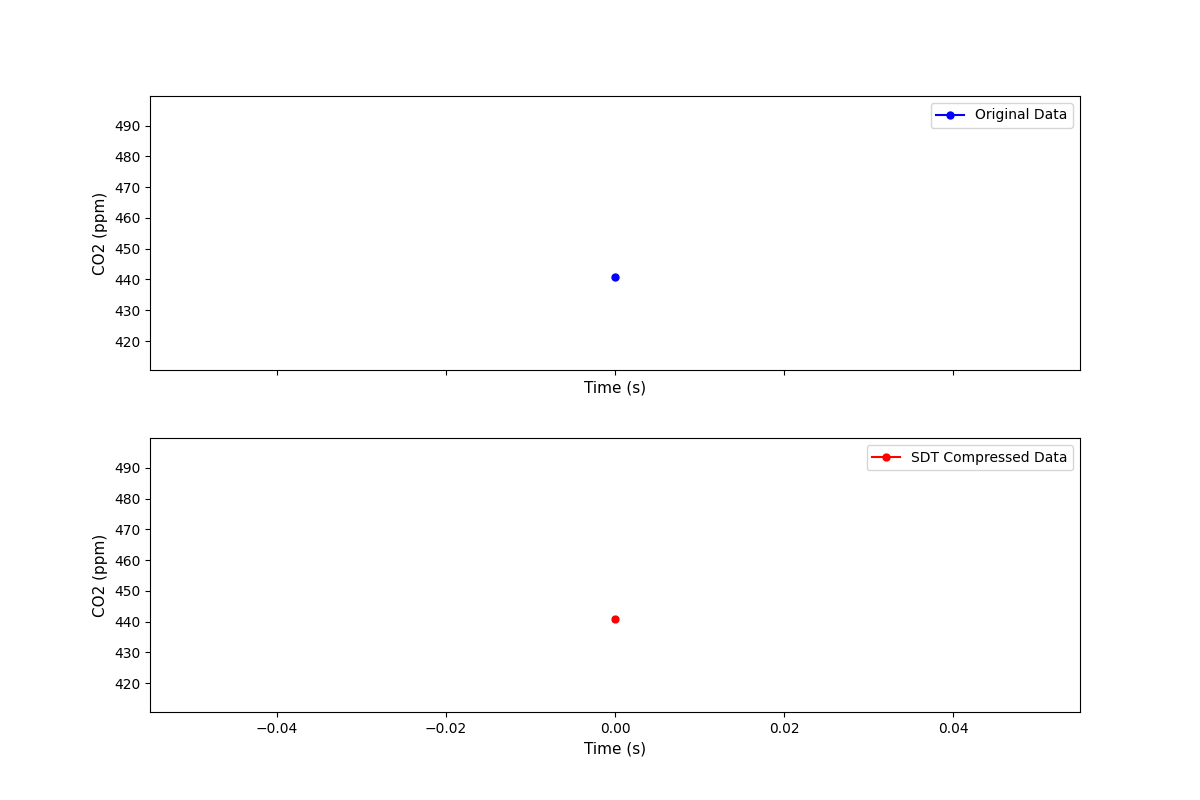

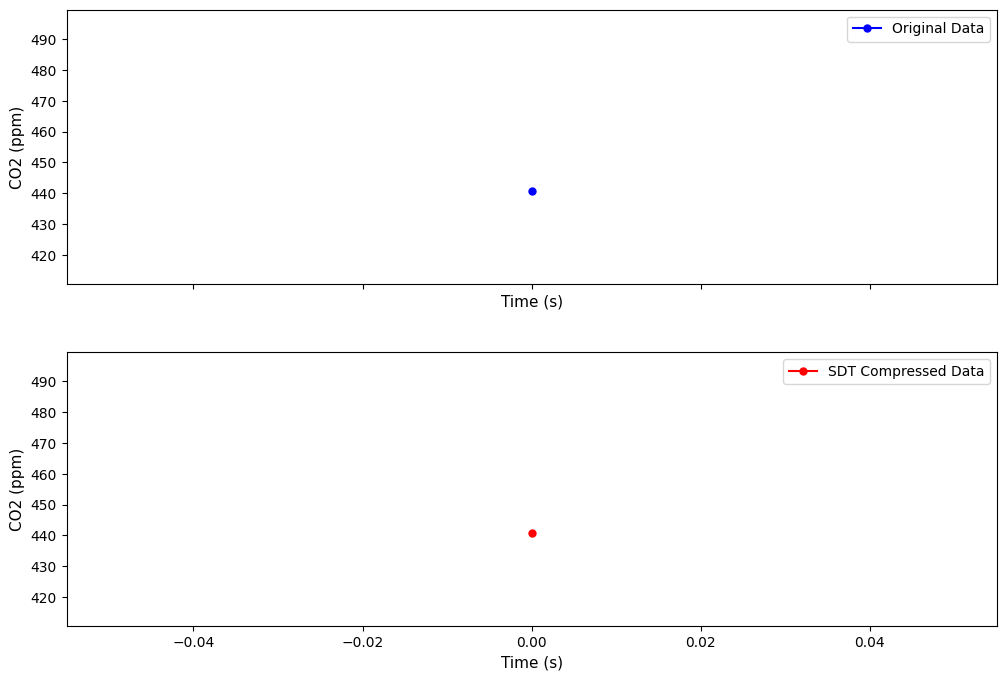

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from statsmodels.tsa.arima_process import ArmaProcess
from IPython.display import Image, display

# Generate autocorrelated time-series data
np.random.seed(60)
ar = np.array([1, -0.9])
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)
values = arma_process.generate_sample(nsample=50) * 10 + 450
timestamps = np.arange(len(values))

# Swinging Door Algorithm parameters
compression_deviation = 5

# Modified Swinging Door Algorithm implementation
compressed_data = [(timestamps[0], values[0])]
excluded_data = []
start_idx = 0
upper_slope = lower_slope = None
decision_points = []

for i in range(1, len(values)):
    current_slope = (values[i] - values[start_idx]) / (timestamps[i] - timestamps[start_idx])
    
    if upper_slope is None:
        upper_slope = current_slope + compression_deviation / (timestamps[i] - timestamps[start_idx])
        lower_slope = current_slope - compression_deviation / (timestamps[i] - timestamps[start_idx])
    else:
        upper_slope = min(upper_slope, current_slope + compression_deviation / (timestamps[i] - timestamps[start_idx]))
        lower_slope = max(lower_slope, current_slope - compression_deviation / (timestamps[i] - timestamps[start_idx]))
    
    if i == len(values) - 1 or current_slope > upper_slope or current_slope < lower_slope:
        compressed_data.append((timestamps[i-1], values[i-1]))  # Save the previous point
        excluded_data.extend([(timestamps[j], values[j]) for j in range(start_idx+1, i-1)])
        decision_points.append((timestamps[i], values[i]))  # Record the point that triggered the save
        start_idx = i - 1  # Update start_idx to the previous point
        upper_slope = lower_slope = None

# Add the last point
if compressed_data[-1][0] != timestamps[-1]:
    compressed_data.append((timestamps[-1], values[-1]))

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.25)

def update(frame):
    axs[0].clear()
    axs[1].clear()
    
    y_min, y_max = min(values), max(values)
    y_range = y_max - y_min
    y_limits = (y_min - 0.1*y_range, y_max + 0.1*y_range)
    
    # Top graph: full data
    axs[0].plot(timestamps[:frame+1], values[:frame+1], 'bo-', mfc='blue', markersize=5, label="Original Data")
    
    # Plot excluded points as hollow circles in top graph
    current_excluded = [(t, v) for t, v in excluded_data if t <= timestamps[frame]]
    if current_excluded:
        ex_timestamps, ex_values = zip(*current_excluded)
        axs[0].plot(ex_timestamps, ex_values, 'o', color='blue', mfc='white', markersize=5)
    
    axs[0].set_xlabel("Time (s)", fontsize=11)
    axs[0].set_ylabel("CO2 (ppm)", fontsize=11)
    axs[0].legend()
    axs[0].set_ylim(y_limits)
    
    # Bottom graph: compressed data
    current_comp_data = [(t, v) for t, v in compressed_data if t <= timestamps[frame]]
    current_comp_timestamps, current_comp_values = zip(*current_comp_data)
    axs[1].plot(current_comp_timestamps, current_comp_values, 'ro-', mfc='red', markersize=5, label="SDT Compressed Data")
    
    # Plot excluded points
    if current_excluded:
        axs[1].plot(ex_timestamps, ex_values, 'o', color='red', mfc='none', markersize=5, label="Excluded Data")
        
    axs[1].set_xlabel("Time (s)", fontsize=11)
    axs[1].set_ylabel("CO2 (ppm)", fontsize=11)
    axs[1].legend()
    axs[1].set_ylim(y_limits)
    
    # Add swinging door visualization for current interval
    if len(current_comp_data) > 1:
        start_time, start_value = current_comp_data[-1]
        end_time, end_value = timestamps[frame], values[frame]
        
        time_diff = end_time - start_time
        value_diff = end_value - start_value
        
        slope = value_diff / time_diff
        upper_slope = slope + compression_deviation / time_diff
        lower_slope = slope - compression_deviation / time_diff
        
        upper_line = [start_value, start_value + upper_slope * time_diff]
        lower_line = [start_value, start_value + lower_slope * time_diff]
        
        axs[0].plot([start_time, end_time], upper_line, '--', color='blue', alpha=0.5)
        axs[0].plot([start_time, end_time], lower_line, '--', color='blue', alpha=0.5)
        axs[0].fill_between([start_time, end_time], upper_line, lower_line, color='blue', alpha=0.1)
    
    legend = False
    # Highlight decision points and draw lines to last saved point
    for i, (dp_time, dp_value) in enumerate(decision_points):
        if dp_time <= timestamps[frame]:
            # Draw line from last saved point to decision point
            if i < len(compressed_data) - 1:
                last_saved = compressed_data[i]
                axs[0].plot([last_saved[0], dp_time], [last_saved[1], dp_value], 'r-', alpha=0.7, label="Decision Points")
                if legend == False: 
                    axs[0].legend()
                    legend = True

    # Add light grey lines for previous intervals
    for i in range(len(current_comp_data) - 1):
        start_time, start_value = current_comp_data[i]
        end_time, end_value = current_comp_data[i+1]
        
        time_diff = end_time - start_time
        value_diff = end_value - start_value
        
        slope = value_diff / time_diff
        upper_slope = slope + compression_deviation / time_diff
        lower_slope = slope - compression_deviation / time_diff
        
        upper_line = [start_value, start_value + upper_slope * time_diff]
        lower_line = [start_value, start_value + lower_slope * time_diff]
        
        axs[0].plot([start_time, end_time], upper_line, '--', color='lightgrey', alpha=0.8)
        axs[0].plot([start_time, end_time], lower_line, '--', color='lightgrey', alpha=0.8)
        axs[0].fill_between([start_time, end_time], upper_line, lower_line, color='lightgrey', alpha=0.1)

ani = FuncAnimation(fig, update, frames=len(timestamps), repeat=False)

ani.save("swinging_door_autocorrelated.gif", writer='pillow', fps=1)
print("GIF saved as 'swinging_door_autocorrelated.gif'")

display(Image(filename="swinging_door_autocorrelated.gif"))